**ITMO University**

**Lectures "Computations in Physics" spring 2016**


Konstantin Ladutenko

recommended book: Anastasis C. Polycarpou "Introduction to the Finite Element Method in Electromagnetics" (doi:10.2200/S00019ED1V01Y200604CEM004)

**<font size="5">Solving 1D Poisson`s problem with Finite Element Method (FEM)</font>**

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

Initialize the notebook, import all needed libs

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sympy import *
from IPython.display import display, Math, Latex
from fractions import Fraction
from sympy import symbols
from sympy.plotting import plot

#init_printing(use_latex='mathjax')
init_printing()
def latex_print( str ):
   "Helper to print LaTeX strings, takes raw string (like r'string')"    
   display(Latex(str))
   return
init_printing()  


# Analytical solution

Basic example of Python SymPy usage.
Set one dimensional Poisson`s equation

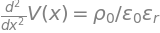

In [2]:

# Define symbols
x, rho_0, eps_r, eps_0 ,d= symbols("x,rho_0,varepsilon_r,varepsilon_0,d")
V = Function('V')(x)
V_0, V_d = symbols("V_0, V_d")
c_1, c_0 = symbols("c_1, c_0")

#The equation
eq = rho_0/(eps_0*eps_r)       ###### Right-hand side
Rel(diff(V,x,2), eq)


Integrate it twice

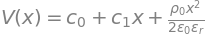

In [3]:
###### Manually adding constants to integration
Veq = integrate(integrate(eq,x) + c_1,x)+c_0   
Rel(V,Veq)

Add *Dirichlet* boundary condition

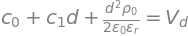

In [4]:
display(Rel(Veq.replace(x,0), V_0))       ###### x=0
display(Rel(Veq.replace(x,d), V_d))

So, we can simply substitute $c_0$ with $V_0$

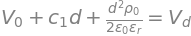

In [5]:
eq1 = Veq.replace(x,d).replace(c_0, V_0)
display(Rel(eq1, V_d))

and solve it for $c_1$

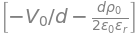

In [6]:
solution = solve(eq1,c_1)
display(solution)

Put $c_0$ and $c_1$ to $V$ equation

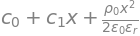

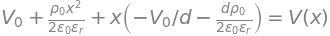

In [7]:
display(Veq)
solved = Veq.replace(c_0,V_0).replace(c_1,solution[0])
display(Rel(solved,V))

Output the solution as a string for evaluation

In [8]:
str(solved)

'V_0 + rho_0*x**2/(2*varepsilon_0*varepsilon_r) + x*(-V_0/d - d*rho_0/(2*varepsilon_0*varepsilon_r))'

Evaluate analytical solution

In [9]:
varepsilon_0 = 8.8541878176*10e-12 #F/m
varepsilon_r = 1
V_0 = 1 #Volt
d = 0.08 #m
rho_0 = 10e-8 # C/m**3
x = symbols('x')
evaluate = (V_0 + rho_0*x**2/(2*varepsilon_0*varepsilon_r)
            + x*(-V_0/d - d*rho_0/(2*varepsilon_0*varepsilon_r)))
print(evaluate)  ## Check substitution
print(evaluate.subs({x:0.08})) # Check right boundary
nmax = 50  # Number of samples for plotting
x_vec = np.linspace(0.0, d, num=nmax)
y_vec = np.array([ evaluate.subs({x:value}) for value in x_vec])  

564.704533380374*x**2 - 57.6763626704299*x + 1
0


Plot the solution

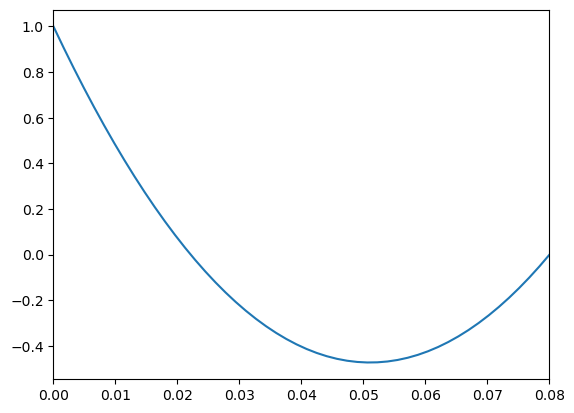

In [10]:
fig, ax = plt.subplots()
ax.plot(x_vec, y_vec);
ax.set_xlim(0,0.08);

# FEM derivation

## Split into finite elements, approximate the solution with shape (interpolation) functions.

We can split our 1D continuous space into uniform line segments (cells), and we will address them as finite elements. Each element has coordinates $x_1$ and $x_2$, which correspond to local nodes 1 and 2 of the element. We can transform this coordinates to the natural ones (related to the reference cell):
$$\xi = \frac{2(x-x_1)}{x_2-x_1}-1$$
This way the coordinate inside the cell will be $(−1 \leq \xi \leq 1)$. We will use uniform domain discretization and approximate the solution with linear shape functions:
$$N_1(\xi)=\frac{1-\xi}{2}$$
$$N_2(\xi)=\frac{1+\xi}{2}$$
At any point inside the master (reference) element, the primary unknown quantity of potential $V$ can be expressed as approximate value
$$
\widetilde{V}(\xi)=V_1N_1(\xi)+V_2N_2(\xi)
$$ 
or we can map it back to the real cell
$$
\widetilde{V}(x)=\left.\sum_{j=1}^{n}v_j N_j(x)\right|_{n=2}
$$
where $v_j$ are the solution values at the nodes of the element.

## Galerkin method

Note: we will use $\rho_v=-\rho_0$ and $\varepsilon = \varepsilon_r \varepsilon_0$

We can rewrite the Poisson`s equation

$$\frac{d}{dx}\left(\varepsilon\frac{dV}{dx}\right)+\rho_v=0$$
Weak form of this equation can be applied to the approximate solution $\widetilde{V}$. In other words, if we have found such a $\widetilde{V}$ that fits well to the original Poisson`s equation it should be also correct to multiply both sides of the equation with an arbitrary test function $\omega$ and integrate it over the domain:

$$
\int_{x_1}^{x_2} \omega 
 \left[\frac{d}{dx} \left( 
 \varepsilon\frac{d\widetilde{V}}{dx}
 \right)+\rho_v
\right] dx =0
$$

It is often preferred that the weight functions $\omega(x)$ be identical to the interpolation or shape functions $N (x)$. This approach is known as the **Galerkin finite element
method**. We will start with integration by parts to rewrite the first term of the equation above, using:
    $$\int_a^b U dV = UV|_a^b + \int_a^b V dU$$
we can get:
$$\int_{x_1}^{x_2} \omega 
\left[d\left( 
 \varepsilon\frac{d\widetilde{V}}{dx}
 \right)
\right]=
\omega \varepsilon
\left.\frac{d\widetilde{V}}{dx}
\right|_{x_1}^{x_2}-\int_{x_1}^{x_2} \left( \frac{d\omega}{dx} \right) 
   \varepsilon\frac{d\widetilde{V}}{dx}dx$$

Thus, the weak formulation of the governing differential equation can be expressed as

$$\int_{x_1}^{x_2}\left(\frac{d\omega}{dx}\right)\varepsilon\frac{d\widetilde{V}}{dx}
dx-\int_{x_1}^{x_2} \omega \rho_v dx -
\omega \varepsilon 
  \left.\frac{d\widetilde{V}}{dx}
  \right|_{x_1}^{x_2}  
= 0$$
or

$$\int_{x_1}^{x_2} \left( \frac{d\omega}{dx} \right) 
\varepsilon\frac{d\widetilde{V}}{dx}dx=
\int_{x_1}^{x_2} \omega \rho_v dx +
\omega   \varepsilon 
  \left.\frac{d\widetilde{V}}{dx}
  \right|_{x_1}^{x_2}$$

By definition of the electric displacement
$$D_x = -\varepsilon\frac{dV}{dx} $$ 
so

$$
\omega \varepsilon 
\left.\frac{d\widetilde{V}}{dx}
 \right|_{x_1}^{x_2} =
     \omega(x_1) \widetilde{D}_x (x_1) - \omega(x_2) \widetilde{D}_x (x_2)
$$

and the full equation is

$$
\int_{x_1}^{x_2}\left( \frac{d\omega}{dx} \right) \varepsilon\frac{d\widetilde{V}}{dx}dx=
\int_{x_1}^{x_2} \omega \rho_v dx + \omega(x_1)\widetilde{D}_x (x_1)-\omega(x_2)\widetilde{D}_x (x_2)$$

The last step in Galerkin method is to use shape functions $N(x)$ as weight functions $\omega(x)$ 
and substitute
$$\widetilde{V}(x)= \sum_{j=1}^{n} v_j N_j(x)$$

Here, for 1D case we have selected 
$$N_1(\xi)=\frac{1-\xi}{2}$$
$$N_2(\xi)=\frac{1+\xi}{2}$$
This way, $N_1(x_1) = 1$, $N_1(x_2) = 0$, $N_2(x_1) = 0$, $N_2(x_2) = 1$

And for both test functions we will get an equation system
$$\int_{x_1}^{x_2} \left( \frac{dN_1}{dx} \right) \varepsilon 
  \left( \sum_{j=1}^{2}   v_j \frac{dN_j }{dx}
   \right)dx=
\int_{x_1}^{x_2} N_1 \rho_v dx + \widetilde{D}_x (x_1)$$
$$\int_{x_1}^{x_2} \left( \frac{dN_2}{dx} \right) 
   \varepsilon 
   \left(
   \sum_{j=1}^{2}   v_j \frac{dN_j }{dx}
   \right)dx=
\int_{x_1}^{x_2} N_2 \rho_v dx - \widetilde{D}_x (x_2)$$

In matrix form
$$\begin{bmatrix}
    K_{11}       & K_{12}\\
    K_{21}       & K_{22}
\end{bmatrix}
\begin{bmatrix}
   v_{1}\\
   v_{2}
\end{bmatrix} =
\begin{bmatrix}
   f_{1}\\
   f_{2}
\end{bmatrix} +
\begin{bmatrix}
   \widetilde{D}_{1}\\
   -\widetilde{D}_{2}
\end{bmatrix}$$

where
$$K_{ij} = \int_{x_1}^{x_2} \left( \frac{dN_i}{dx} \right) \varepsilon 
\left(\frac{dN_j }{dx}
\right) dx$$
and
$$f_i=\int_{x_1}^{x_2}N_i\rho_v dx$$

As soon as $N_i$ is a linear function that changes by 1 on the length of the cell $l=x_2-x_1$ it is very easy to evaluate the above integrals, thus

$$K=\frac{\varepsilon}{l}
\begin{bmatrix}
     1  &  -1\\
    -1  &   1
\end{bmatrix}$$
and using $\rho_v = -\rho_0$ 
$$f= -\frac{l \rho_0}{2}
\begin{bmatrix}
    1\\
    1
\end{bmatrix}$$

Finally, the governing matrix system for a single element is given by
$$\frac{\varepsilon}{l}
\begin{bmatrix}
    1  &  -1\\
   -1  &   1
\end{bmatrix}
\begin{bmatrix}
   v_{1}\\
   v_{2}
\end{bmatrix}= -\frac{l \rho_0}{2}
\begin{bmatrix}
   1\\
   1
\end{bmatrix} +
\begin{bmatrix}
   \widetilde{D}_{1}\\
   -\widetilde{D}_{2}
\end{bmatrix}$$

## Assembly of Elements

At the beginning, let`s consider the case of two connected cells (finite elements, in 1D case they are segments). For each of them, we have a matrix equation, with $^{(1)}$ superscript for the first element and $^{(2)}$ for the second one. With the regular meshing, the length for all elements is the same, e.g. $l^{(1)}=l^{(2)}=l$

$$\frac{\varepsilon^{(1)}}{l}
\begin{bmatrix}
    1  &  -1\\
   -1  &   1
\end{bmatrix}
\begin{bmatrix}
v_{1}^{(1)}\\
v_{2}^{(1)} \end{bmatrix} = -\frac{l \rho_0}{2}
\begin{bmatrix}
  1\\
  1
\end{bmatrix} +
\begin{bmatrix}
  \widetilde{D}_1^{(1)} \\
  -\widetilde{D}_{2}^{(1)}
\end{bmatrix}$$

$$\frac{\varepsilon^{(2)}}{l}
\begin{bmatrix}
     1  &  -1\\
    -1  &   1
\end{bmatrix}
\begin{bmatrix}
   v_{1}^{(2)}\\
   v_{2}^{(2)}
\end{bmatrix}= -\frac{l \rho_0}{2}
\begin{bmatrix}
   1\\
   1
\end{bmatrix}  +
\begin{bmatrix}
   \widetilde{D}_{1}^{(2)}\\
   -\widetilde{D}_{2}^{(2)}
\end{bmatrix}$$

As soon as elements are connected, the potential has the same value at the point of the connection
$$v_{2}^{(1)} = v_{1}^{(2)}$$

We can introduce the global enumeration for the primary unknown quantity of potential, so let`s consider
$$\widetilde{V}_0 = v_{1}^{(1)}$$
$$\widetilde{V}_1 = v_{2}^{(1)} = v_{1}^{(2)}$$
$$\widetilde{V}_2 = v_{2}^{(2)}$$

Now the equation systems for each element can be written in the equivalent form of

$$\frac{\varepsilon^{(1)}}{l}
\begin{bmatrix}
  1  &  -1 & 0\\
 -1  &   1 & 0\\
  0  &   0 & 0
\end{bmatrix}
\begin{bmatrix}
 \widetilde{V}_0\\
 \widetilde{V}_1\\
 \widetilde{V}_2
\end{bmatrix}
= -\frac{l \rho_0}{2}
\begin{bmatrix}
 1\\
 1\\
 0\\
\end{bmatrix} 
+
\begin{bmatrix}
   \widetilde{D}_{1}^{(1)}\\
   -\widetilde{D}_{2}^{(1)}\\
   0
\end{bmatrix}$$

$$\frac{\varepsilon^{(2)}}{l}
\begin{bmatrix}
     0  &   0 &  0\\
     0  &   1 & -1\\
     0  &  -1 &  1
\end{bmatrix}
\begin{bmatrix}
    \widetilde{V}_0\\
    \widetilde{V}_1\\
    \widetilde{V}_2
\end{bmatrix}
= -\frac{l \rho_0}{2}
\begin{bmatrix}
    0\\
    1\\
    1\\
\end{bmatrix} 
+
\begin{bmatrix}
    0\\
    \widetilde{D}_{1}^{(2)}\\
    -\widetilde{D}_{2}^{(2)}    
\end{bmatrix}$$

As far as problem domain uses a homogeneous distribution of material parameter $\varepsilon^{(1)} = \varepsilon^{(2)} = \varepsilon$ and we can simply add one equation system to another, and summarize the equations that correspond to the same row of the extended $K$ matrix.

$$\frac{\varepsilon}{l}
\begin{bmatrix}
     1  &   -1 &  0\\
     -1  &   2 & -1\\
     0  &  -1 &  1
\end{bmatrix}
\begin{bmatrix}
    \widetilde{V}_0\\
    \widetilde{V}_1\\
    \widetilde{V}_2
\end{bmatrix}
= -\frac{l \rho_0}{2}
\begin{bmatrix}
    1\\
    2\\
    1\\
\end{bmatrix} 
+
\begin{bmatrix}
 \widetilde{D}_{1}^{(1)}\\
    -\widetilde{D}_{2}^{(1)}+    \widetilde{D}_{1}^{(2)}\\
    -\widetilde{D}_{2}^{(2)}    
\end{bmatrix}$$

For homogeneous charge distribution $\rho_0$ and small elements (so, the change of the potential is smooth enough in the neighbor cells) the difference $\widetilde{D}_{1}^{(2)} -\widetilde{D}_{2}^{(1)} \simeq 0$

$$\frac{\varepsilon}{l}
\begin{bmatrix}
     1  &   -1 &  0\\
     -1  &   2 & -1\\
     0  &  -1 &  1
\end{bmatrix}
\begin{bmatrix}
    \widetilde{V}_0\\
    \widetilde{V}_1\\
    \widetilde{V}_2
\end{bmatrix}
= -\frac{l \rho_0}{2}
\begin{bmatrix}
    1\\
    2\\
    1\\
\end{bmatrix} 
+
\begin{bmatrix}
 \widetilde{D}_{1}^{(1)}\\
    0\\
    -\widetilde{D}_{2}^{(2)}    
\end{bmatrix}$$

This form can easily be extended to any number of finite elements in the model, e.g. system from 4 elements:
$$\frac{\varepsilon}{l}
\begin{bmatrix}
     1  &   -1 &  0 & 0 & 0\\
     -1  &   2 & -1 & 0 & 0\\
      0 & -1  &   2 & -1 & 0\\
      0 & 0 &-1  &   2 & -1\\
       0 & 0 & 0  &  -1 &  1 
\end{bmatrix}
\begin{bmatrix}
    \widetilde{V}_0\\
    \widetilde{V}_1\\
    \widetilde{V}_2\\
    \widetilde{V}_3\\
    \widetilde{V}_4
\end{bmatrix}
= -\frac{l \rho_0}{2}
\begin{bmatrix}
    1\\
    2\\
    2\\
    2\\
    1\\
\end{bmatrix} 
+
\begin{bmatrix}
 \widetilde{D}_{1}^{(1)}\\
    0\\
    0\\
    0\\
    -\widetilde{D}_{2}^{(2)}    
\end{bmatrix}$$

To apply Dirichlet boundary condition to the left boundary of the first element we can directly substitute it into the equation system. For $\widetilde{V}_0 = V_0$ we remove the first equation (the first row) and move the first column of the $K$ matrix to the right 

$$\frac{\varepsilon}{l}
\begin{bmatrix}     
      2 & -1 &   0 &  0\\
    -1  &  2 &  -1 &  0\\
      0 &-1  &   2 & -1\\
      0 & 0  &  -1 &  1 
\end{bmatrix}
\begin{bmatrix}    
    \widetilde{V}_1\\
    \widetilde{V}_2\\
    \widetilde{V}_3\\
    \widetilde{V}_4
\end{bmatrix}
= -\frac{l \rho_0}{2}
\begin{bmatrix}    
    2\\
    2\\
    2\\
    1\\
\end{bmatrix} 
+
\begin{bmatrix}
    0\\
    0\\
    0\\
    -\widetilde{D}_{2}^{(2)}    
\end{bmatrix} -
\frac{\varepsilon}{l}
\begin{bmatrix}     
     -1  \\
      0 \\
      0 \\
       0  
\end{bmatrix}
V_0$$

Same for the right boundary of the last element. For $\widetilde{V}_4 = 0$ we remove the last equation (the bottom row) and remove the last column in $K$ matrix (it disappears after multiplication to zero value of the potential at the boundary). We also do not use $\widetilde{D}$ vector anymore, as soon as it equals zero too.

$$\frac{\varepsilon}{l}
\begin{bmatrix}     
      2 & -1 &   0 \\
    -1  &  2 &  -1 \\
      0 &-1  &   2 \\
\end{bmatrix}
\begin{bmatrix}    
    \widetilde{V}_1\\
    \widetilde{V}_2\\
    \widetilde{V}_3\\
\end{bmatrix}
= -\frac{l \rho_0}{2}
\begin{bmatrix}    
    2\\
    2\\
    2\\
\end{bmatrix} -
\frac{\varepsilon}{l}
\begin{bmatrix}     
     -1  \\
      0 \\
      0 \\   
\end{bmatrix}
V_0$$

Multiply $l/\varepsilon$
$$\begin{bmatrix}     
      2 & -1 &   0 \\
    -1  &  2 &  -1 \\
      0 &-1  &   2 \\
\end{bmatrix}
\begin{bmatrix}    
    \widetilde{V}_1\\
    \widetilde{V}_2\\
    \widetilde{V}_3\\
\end{bmatrix}
= -\frac{l^2 \rho_0}{\varepsilon}
\begin{bmatrix}    
    1\\
    1\\
    1\\
\end{bmatrix} -
\begin{bmatrix}     
     -1  \\
      0 \\
      0 \\   
\end{bmatrix}
V_0$$

# FEM implementation

[[ 2. -1.  0.]
 [-1.  2. -1.]
 [ 0. -1.  2.]]
[ 1.          0.07235456 -0.40352725 -0.42764544  0.        ]
<class 'sympy.core.add.Add'>


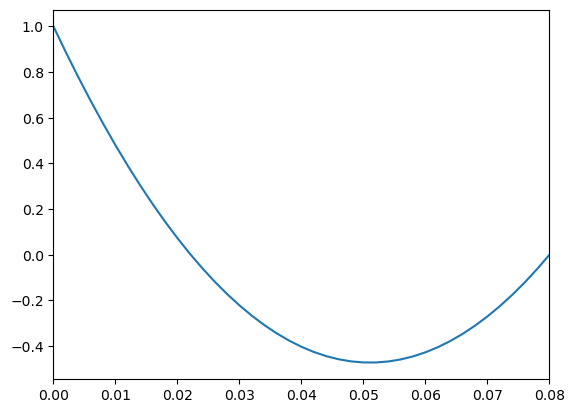

In [14]:
# Set the model
eps_0 = 8.8541878176*10e-12 #F/m
eps_r = 1.0
eps = eps_0*eps_r
rho_0 = 10e-8 # C/m**3
V_0 = 1.0 #Volt

d = 0.08 #m
number_of_elements = 4

l=d/number_of_elements

# After elimination of the equation system using 
# Dirichlet boundary condition we have less equations...
K = np.zeros((number_of_elements-1,
              number_of_elements-1))
for i in range(number_of_elements-1):
    for j in range(number_of_elements-1):
        if i == j: K[i,j]=2
        if abs(i-j) == 1:
            K[i,j] = -1
print(K)

# Still we need all values of the potential
V = np.zeros(number_of_elements + 1)
V[0] = V_0

# Set the right-hand side
f = np.ones(number_of_elements-1)*(-(l**2)*rho_0)/(eps)
f[0] += V_0

# Solve the system
V[1:-1] = np.linalg.solve(K,f)
print(V)

#Plot it with analytic solution.
x_fem = np.linspace(0.0, d, num=number_of_elements+1)
evaluate = (V_0 + rho_0*x**2/(2*varepsilon_0*varepsilon_r)
            + x*(-V_0/d - d*rho_0/(2*varepsilon_0*varepsilon_r)))
print(type(evaluate))
x_vec = np.linspace(0.0, d, num=number_of_elements*10+1)
y_vec = np.array([ evaluate.subs({x:value}) for value in x_vec]) 
fig, ax = plt.subplots()
ax.plot(x_vec, y_vec)#, x_fem,V);
ax.set_xlim(0,0.08);

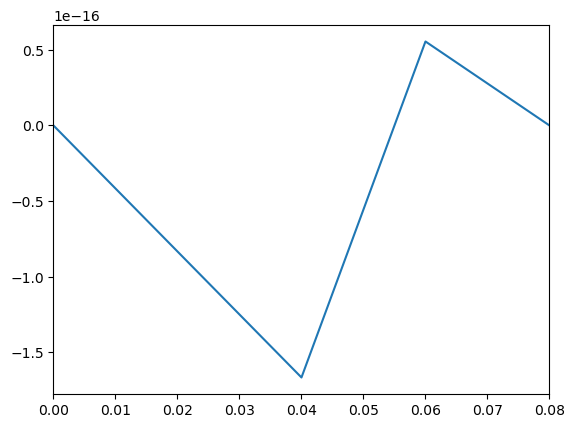

In [12]:
#Error
x_vec = np.linspace(0.0, d, num=number_of_elements+1)
y_vec = np.array([ evaluate.subs({x:value}) for value in x_vec]) 
fig, ax = plt.subplots()
ax.plot(x_vec, (y_vec-V));
ax.set_xlim(0,0.08);

In [13]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e7279866-9353-468f-9ff9-b225e8f1b2ea' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>